# Notebook of comparison VAE and geometric VAE

In [24]:
import numpy as np
import pandas as pd
import scanpy as sc

from scCFM.models.base.vae import VAE
from scCFM.models.base.geometric_vae import GeometricNBVAE
from scCFM.models.base.geodesic_ae import GeodesicAE
from scCFM.datamodules.sc_datamodule import scDataModule

from scCFM.models.manifold.geometry_metrics import compute_all_metrics

import sys
sys.path.insert(0, "../..")
from notebooks.utils import real_reconstructed_cells_adata

from paths import PROJECT_FOLDER
import anndata
import torch

## Initialize the two different configurations 

General module hparams

In [22]:
datamodule={'path': PROJECT_FOLDER / 'data' / 'schiebinger_et_al' / 'processed' / 'schiebinger_et_al.h5ad', 
            'x_layer': 'X_norm', 
            'cond_keys': ['experimental_time', 'cell_sets'],
            'use_pca': False, 
            'n_dimensions': None, 
            'train_val_test_split': [1], 
            'batch_size': 256, 
            'num_workers': 2}

# Initialize datamodule
datamodule = scDataModule(**datamodule)

### Model config VAE

In [23]:
model_vae={
       'in_dim': datamodule.in_dim,
       'n_epochs_anneal_kl': 1000, 
       'kl_weight': None, 
       'likelihood': 'nb', 
       'dropout': False, 
       'learning_rate': 0.001, 
       'dropout_p': False, 
       'model_library_size': True, 
       'batch_norm': True, 
       'kl_warmup_fraction': 0.1, 
       'hidden_dims': [256, 10]}
        
geometric={'compute_metrics_every': 1, 
           'use_c': True, 
           'l2': True, 
           'eta_interp': 0, 
           'interpolate_z': False, 
           'start_jac_after': 0, 
           'fl_weight': 0.1,
           'detach_theta': True}

geodesic={"in_dim": datamodule.in_dim,
          "hidden_dims": [256, 10],
          "batch_norm": True,
          "dropout": False, 
          "dropout_p": False,
          "likelihood": "nb",
          "learning_rate": 0.001}

In [28]:
vae = GeometricNBVAE(**geometric, vae_kwargs=model_vae)
geometric_vae = GeometricNBVAE(**geometric, vae_kwargs=model_vae)
geodesic_ae = GeodesicAE(**geodesic).eval()

In [30]:
vae.load_state_dict(torch.load(PROJECT_FOLDER / "checkpoints/ae/schiebinger_et_al/best_model_vae.ckpt")["state_dict"])
geometric_vae.load_state_dict(torch.load(PROJECT_FOLDER / "checkpoints/ae/schiebinger_et_al/best_model_geometric.ckpt")["state_dict"])
geodesic_ae.load_state_dict(torch.load(PROJECT_FOLDER / "checkpoints/ae/schiebinger_et_al/best_model_geodesic.ckpt")["state_dict"])

<All keys matched successfully>

In [32]:
datamodule.cond_keys

['experimental_time', 'cell_sets']

### Compute UMAPs

In [34]:
adata_vae_z = real_reconstructed_cells_adata(vae, datamodule, process_amortized_adata=False, compute_umap=False, log1p=False, vae=True)
adata_geometric_z = real_reconstructed_cells_adata(geometric_vae, datamodule, process_amortized_adata=False, compute_umap=False, log1p=False, vae=True)
adata_geodesic_z = real_reconstructed_cells_adata(geodesic_ae, datamodule, process_amortized_adata=False, log1p=False, vae=False, model_type="geodesic")

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [35]:
adata_vae_z

AnnData object with n_obs × n_vars = 165888 × 10
    obs: 'experimental_time', 'cell_sets', 'log_library_size'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

Plot the UMAP results

In [36]:
adata_vae_z.obs["cell_sets"] = adata_vae_z.obs["cell_sets"].astype("category")
adata_geometric_z.obs["cell_sets"] = adata_geometric_z.obs["cell_sets"].astype("category")
adata_geodesic_z.obs["cell_sets"] = adata_geodesic_z.obs["cell_sets"].astype("category")

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


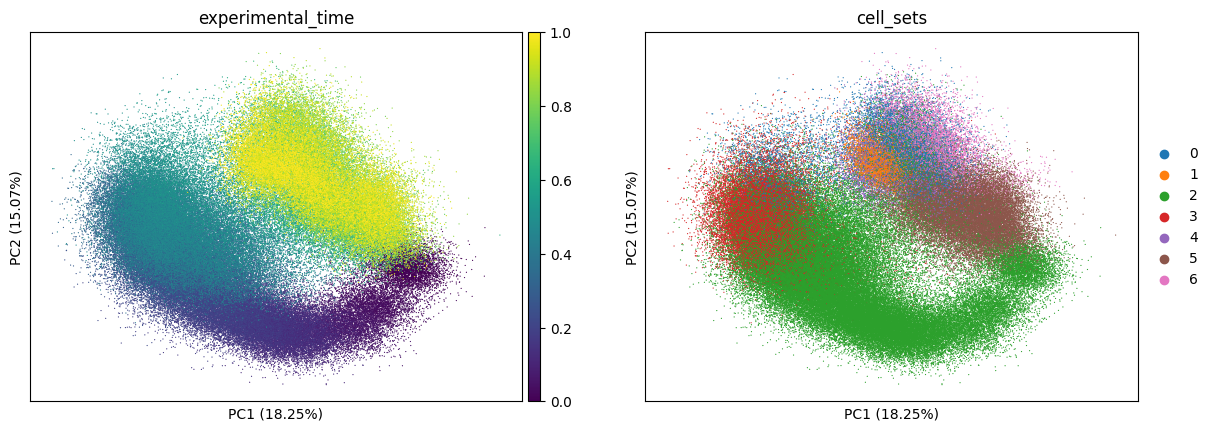

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


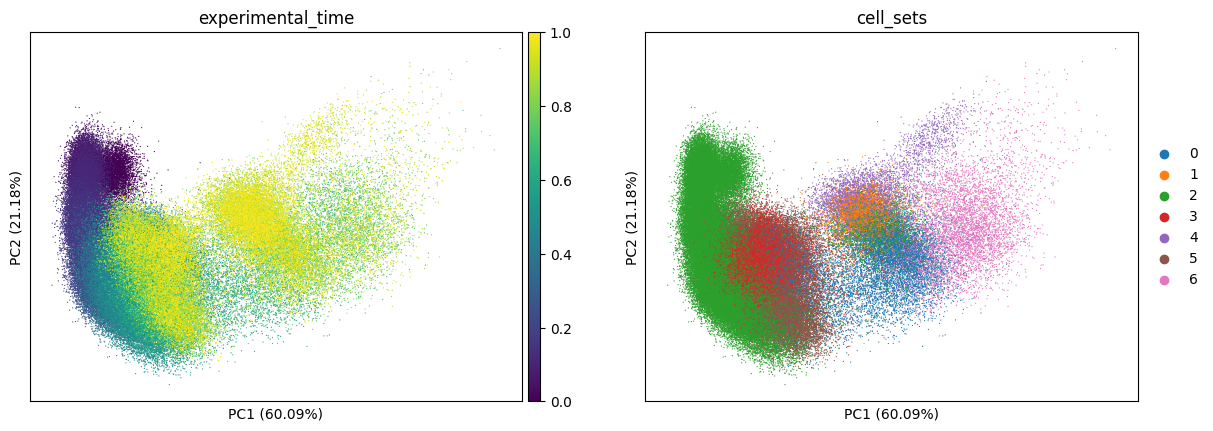

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


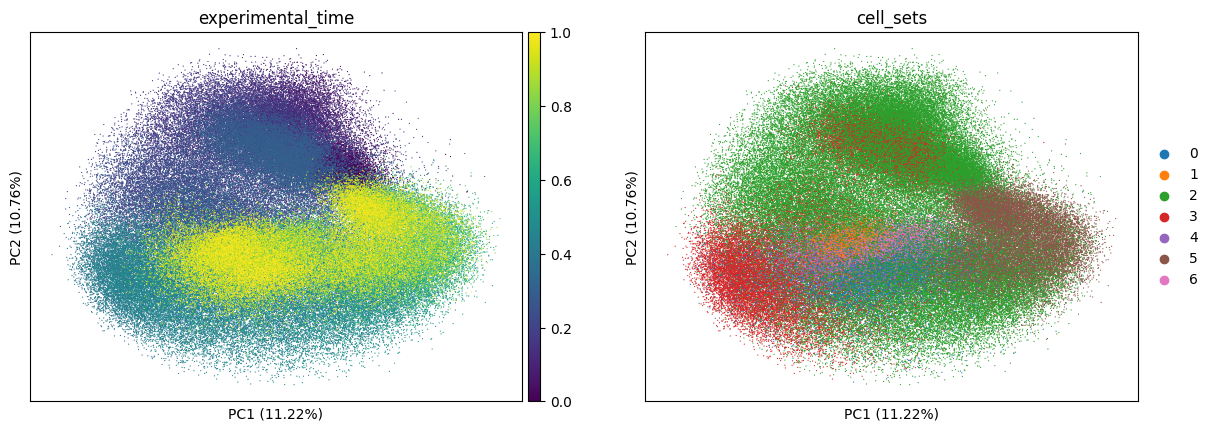

In [37]:
sc.pl.pca(adata_vae_z, color=["experimental_time", "cell_sets"], size=3,add_outline=False, annotate_var_explained=True)
sc.pl.pca(adata_geometric_z, color=["experimental_time", "cell_sets"], size=3, add_outline=False, annotate_var_explained=True)
sc.pl.pca(adata_geodesic_z, color=["experimental_time", "cell_sets"], size=3, add_outline=False, annotate_var_explained=True)

In [23]:
# from pytorch_lightning import Trainer

# trainer_vae = Trainer(inference_mode=False)
# trainer_geometric = Trainer(inference_mode=False)

In [12]:
# trainer_vae.validate(model=vae, dataloaders=datamodule)

In [36]:
# trainer_geometric.validate(model=geometric_vae, 
#                        dataloaders=datamodule)

**Save anndata**

In [40]:
adata_vae_z.layers["X_latents"] = adata_vae_z.X.copy()
adata_vae_z.write_h5ad(PROJECT_FOLDER / "data/schiebinger_et_al/flat/schiebinger_et_al.h5ad")

In [41]:
adata_geometric_z.layers["X_latents"] = adata_geometric_z.X.copy()
adata_geometric_z.write_h5ad(PROJECT_FOLDER / "data/schiebinger_et_al/flat/schiebinger_et_al_flat.h5ad")

In [42]:
adata_geodesic_z.layers["X_latents"] = adata_geometric_z.X.copy()
adata_geodesic_z.write_h5ad(PROJECT_FOLDER / "data/schiebinger_et_al/flat/schiebinger_et_al_geodesic.h5ad")

**Plot together**

In [39]:
annot = ["geometric" for _ in range(len(adata_geometric_z))] + ["normal" for _ in range(len(adata_vae_z))]
concat = anndata.concat([adata_geometric_z, adata_vae_z], merge="same")
concat.obs["dataset_type"] = annot

/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


/nfs/staff-ssd/pala/envs/scCFM/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


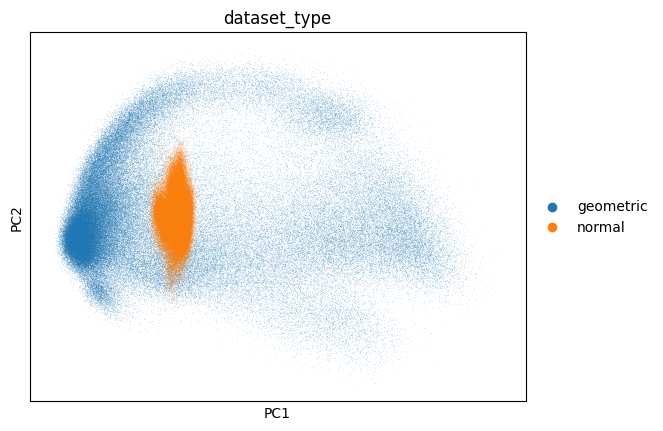

In [40]:
sc.tl.pca(concat)
sc.pl.pca(concat, color="dataset_type")